# Test notebook - develop study of the results


In [1]:
import sys
import os 
os.environ['MPLCONFIGDIR'] = '/myhome'
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), os.path.pardir)))
from data import BavarianCrops, BreizhCrops, SustainbenchCrops, ModisCDL
from earlyrnn import EarlyRNN
import torch
from loss import EarlyRewardLoss
import pandas as pd
from utils.plots import plot_label_distribution_datasets, boxplot_stopping_times
from utils.doy import get_doys_dict_test, get_doy_stop
from utils.helpers_training import parse_args
from utils.helpers_testing import test_dataset, get_test_stats, test_temp_masking
import matplotlib.pyplot as plt
from utils.plots_test import plot_doy_prob, plot_all_doy_probs

In [2]:
import argparse

def parse_args(args=None):
    parser = argparse.ArgumentParser(description='Run ELECTS Early Classification training on the BavarianCrops dataset.')
    parser.add_argument('--dataset', type=str, default="bavariancrops", choices=["bavariancrops","breizhcrops", "ghana", "southsudan","unitedstates"], help="dataset")
    parser.add_argument('--alpha', type=float, default=0.5, help="trade-off parameter of earliness and accuracy (eq 6): "
                                                                 "1=full weight on accuracy; 0=full weight on earliness")
    parser.add_argument('--epsilon', type=float, default=10, help="additive smoothing parameter that helps the "
                                                                  "model recover from too early classifications (eq 7)")
    parser.add_argument('--learning-rate', type=float, default=1e-3, help="Optimizer learning rate")
    parser.add_argument('--weight-decay', type=float, default=0, help="weight_decay")
    parser.add_argument('--patience', type=int, default=30, help="Early stopping patience")
    parser.add_argument('--device', type=str, default="cuda" if torch.cuda.is_available() else "cpu",
                        choices=["cuda", "cpu"], help="'cuda' (GPU) or 'cpu' device to run the code. "
                                                     "defaults to 'cuda' if GPU is available, otherwise 'cpu'")
    parser.add_argument('--epochs', type=int, default=100, help="number of training epochs")
    parser.add_argument('--sequencelength', type=int, default=70, help="sequencelength of the time series. If samples are shorter, "
                                                                "they are zero-padded until this length; "
                                                                "if samples are longer, they will be undersampled")
    parser.add_argument('--hidden-dims', type=int, default=64, help="number of hidden dimensions in the backbone model")
    parser.add_argument('--batchsize', type=int, default=256, help="number of samples per batch")
    parser.add_argument('--dataroot', type=str, default=os.path.join(os.environ.get("HOME", os.environ.get("USERPROFILE")),"elects_data"), help="directory to download the "
                                                                                 "BavarianCrops dataset (400MB)."
                                                                                 "Defaults to home directory.")
    parser.add_argument('--snapshot', type=str, default="snapshots/model.pth",
                        help="pytorch state dict snapshot file")
    parser.add_argument('--resume', action='store_true')

    if args is not None:
        args = parser.parse_args(args)
    else:
        args = parser.parse_args()

    if args.patience < 0:
        args.patience = None

    return args

custom_args = "--dataset breizhcrops --snapshot ./models/breizhcrops_models/elects_lstm/model.pth --sequencelength 150".split()
args = parse_args(custom_args)
print("cuda is available: ", args.device)
print(args)

cuda is available:  cuda
Namespace(dataset='breizhcrops', alpha=0.5, epsilon=10, learning_rate=0.001, weight_decay=0, patience=30, device='cuda', epochs=100, sequencelength=150, hidden_dims=64, batchsize=256, dataroot='C:\\Users\\anyam\\elects_data', snapshot='./models/breizhcrops_models/elects_lstm/model.pth', resume=False)


## Test.py - Test the model


In [3]:
# ----------------------------- LOAD DATASET -----------------------------
if args.dataset == "breizhcrops":
    dataroot = os.path.join(args.dataroot,"breizhcrops")
    nclasses = 9
    input_dim = 13
    doys_dict_test = get_doys_dict_test(dataroot=os.path.join(args.dataroot,args.dataset))
    test_ds = BreizhCrops(root=dataroot,partition="eval", sequencelength=args.sequencelength, return_id=True)
    class_names = test_ds.ds.classname
    print("class names:", class_names)
else:
    raise ValueError(f"dataset {args.dataset} not recognized")


1555075632 1555075632


loading data into RAM: 100%|██████████| 122614/122614 [02:25<00:00, 844.09it/s] 

class names: ['barley' 'wheat' 'rapeseed' 'corn' 'sunflower' 'orchards' 'nuts'
 'permanent meadows' 'temporary meadows']


Extracting labels from dataset Test.


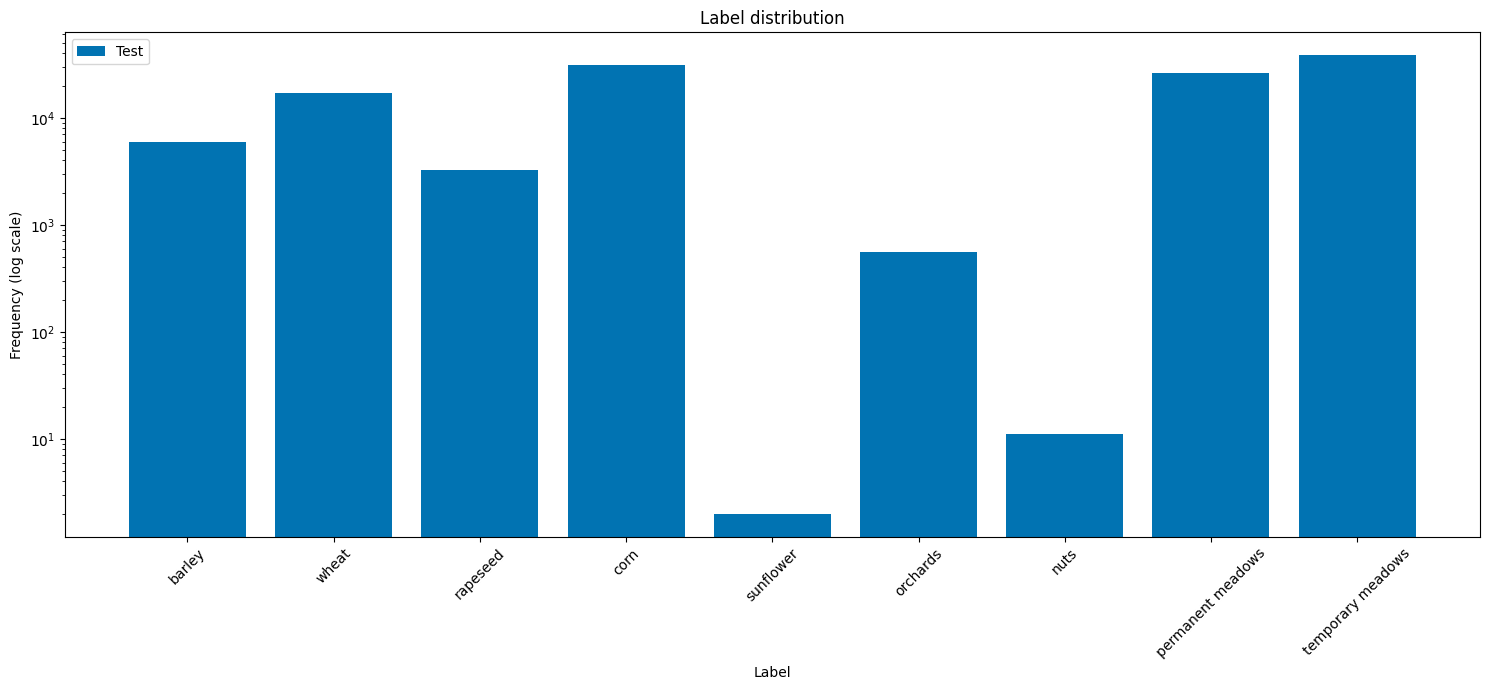

In [4]:
# take about 1 minute
# ----------------------------- VISUALIZATION: label distribution -----------------------------
datasets = [test_ds]
sets_labels = ["Test"]
fig, ax = plt.subplots(figsize=(15, 7))
fig, ax = plot_label_distribution_datasets(datasets, sets_labels, fig, ax, title='Label distribution', labels_names=class_names)

In [5]:
# ----------------------------- LOAD MODEL -----------------------------
model = EarlyRNN(nclasses=nclasses, input_dim=input_dim, hidden_dims=args.hidden_dims, sequencelength=args.sequencelength).to(args.device)
model.load_state_dict(torch.load(args.snapshot))
print("model loaded from", args.snapshot) 
criterion = EarlyRewardLoss(alpha=args.alpha, epsilon=args.epsilon)


model loaded from ./models/breizhcrops_models/elects_lstm/model.pth


In [6]:
# ----------------------------- TEST -----------------------------
testloss, stats = test_dataset(model, test_ds, criterion, args.device, args.batchsize)
test_stats = get_test_stats(stats, testloss, args)


  0%|          | 0/479 [00:00<?, ?it/s]

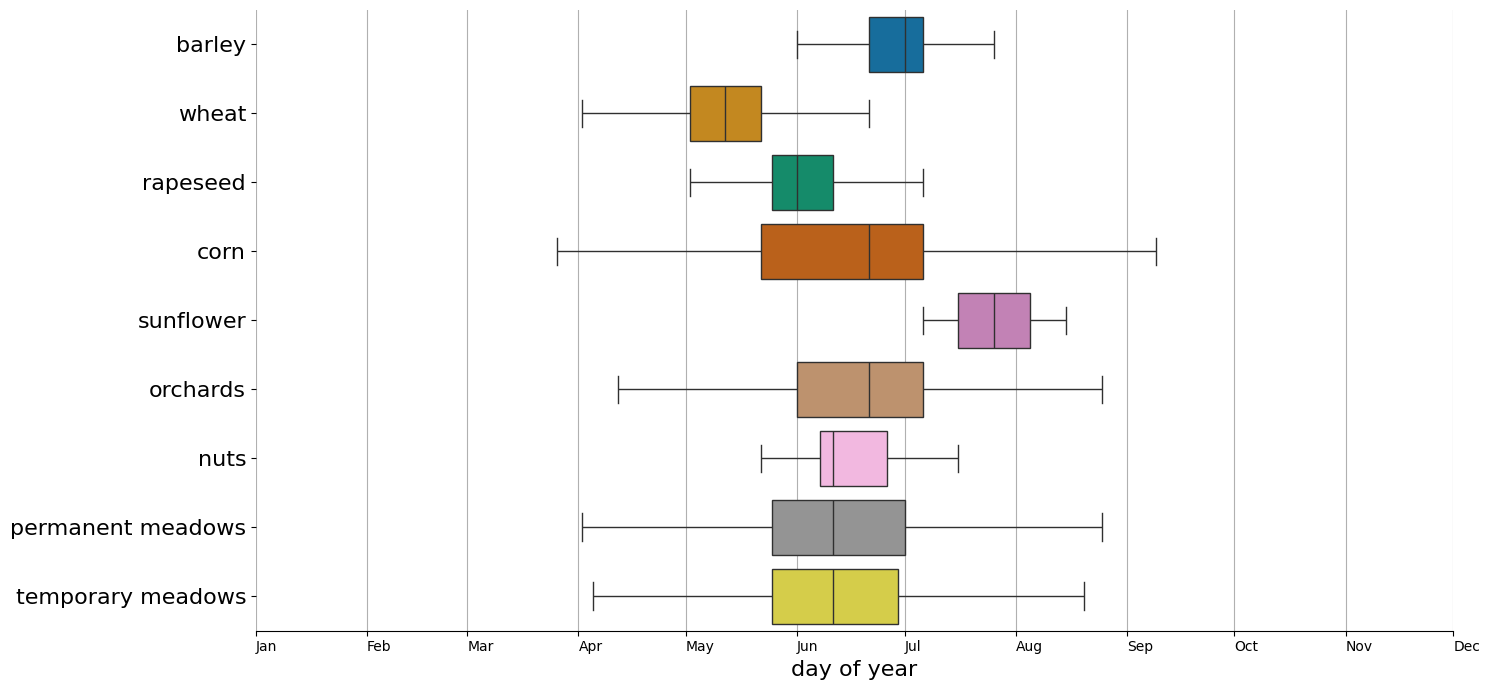

In [7]:
# ----------------------------- VISUALIZATION: stopping times -----------------------------
fig_boxplot, ax_boxplot = plt.subplots(figsize=(15, 7))
doys_stop = get_doy_stop(stats, doys_dict_test, approximated=False)
fig_boxplot, _ = boxplot_stopping_times(doys_stop, stats, fig_boxplot, ax_boxplot, class_names)

(<Figure size 600x400 with 1 Axes>, <Axes: >)

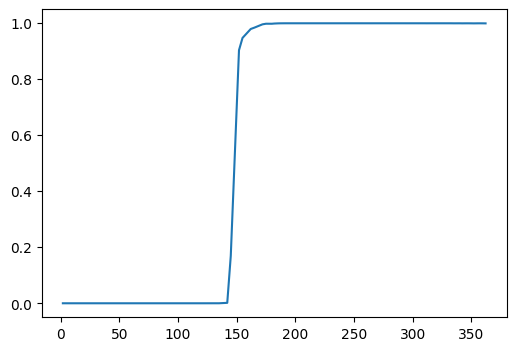

In [8]:
fig, ax = plt.subplots(figsize=(6,4))
plot_doy_prob(6052609, stats, doys_dict_test, model, args.device, test_ds, fig, ax)


for class 0 we have 500 samples
for class 1 we have 500 samples
for class 2 we have 500 samples
for class 3 we have 500 samples
for class 4 we have 2 samples
for class 5 we have 500 samples
for class 6 we have 11 samples
for class 7 we have 500 samples
for class 8 we have 500 samples


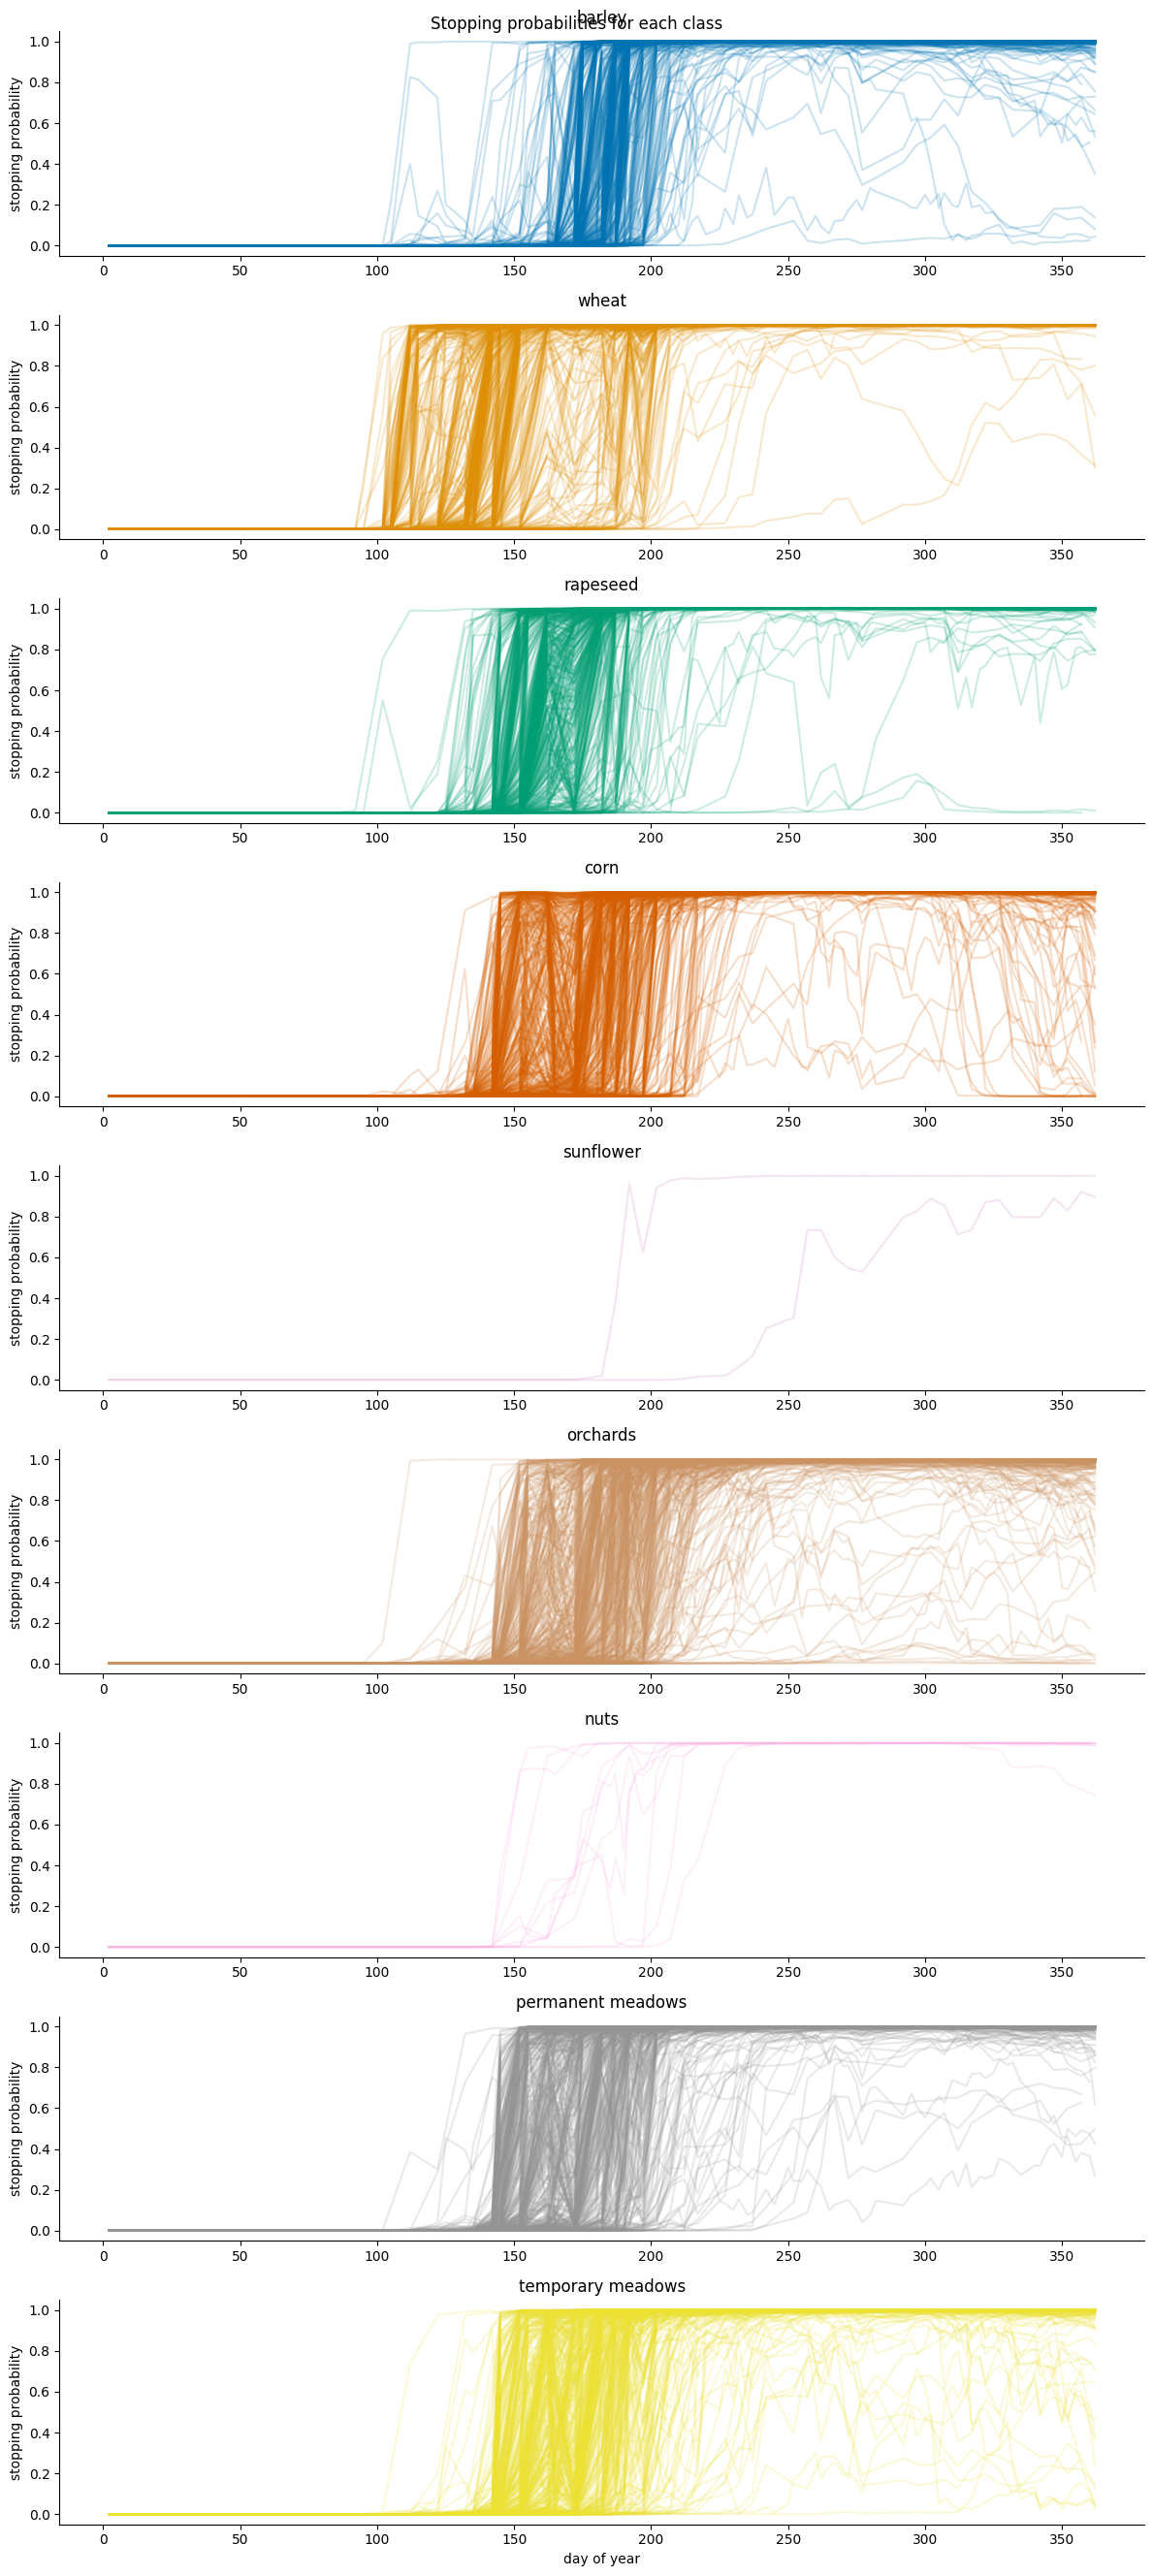

In [9]:
fig, axes = plot_all_doy_probs(stats, doys_dict_test, nclasses=nclasses, class_names=class_names, alpha=0.2, nsamples=500)

In [ ]:
# # ----------------------------- SAVE -----------------------------
# fig.savefig(os.path.join(os.path.dirname(args.snapshot), "label_distribution.png"), bbox_inches='tight')
# fig_boxplot.savefig(os.path.join(os.path.dirname(args.snapshot), "stopping_times.png"), bbox_inches='tight')

# test_stats_df = pd.DataFrame(test_stats, index=[0])
# test_stats_df.to_csv(os.path.join(os.path.dirname(args.snapshot), "test_stats.csv"))
# plt.show()

## Temporal masking
For testing as if in realtime, we will use a temporal mask to simulate realtime acquisition of data. When the stopping probability reaches a certain threshold, the decision is made. This is a simple way to simulate the real-time decision-making process.

The threshold is fixed at `thresh_stop = 0.8`.

In [125]:
# takes about 30 minutes to compute 
testloss, stats = test_temp_masking(model, test_ds, criterion, args.device, args.batchsize, args.sequencelength, step=5)


  0%|          | 0/479 [00:00<?, ?it/s]

In [128]:
# save the test loss to a csv file
test_stats_df = pd.DataFrame(test_stats, index=[0])
test_stats_df.to_csv(os.path.join(os.path.dirname(args.snapshot), "test_stats.csv"))

# save stats as a dictionary
import pickle
with open(os.path.join(os.path.dirname(args.snapshot), "stats.pkl"), 'wb') as f:
    pickle.dump(stats, f)

#### test if the stats are different from the previous version
the boxplot is the a bit different from the previous version, but the results are similar. We expected this result with LSTM. However the results should be different with TempCNN. 
The only difference here is the approach to get t_stop: in the previous version it was computed as the first time when the cumulative sum of the stopping probabilities achieve 1, and in the current version, it is computed as the first time when the stopping probability is greater than a threshold.

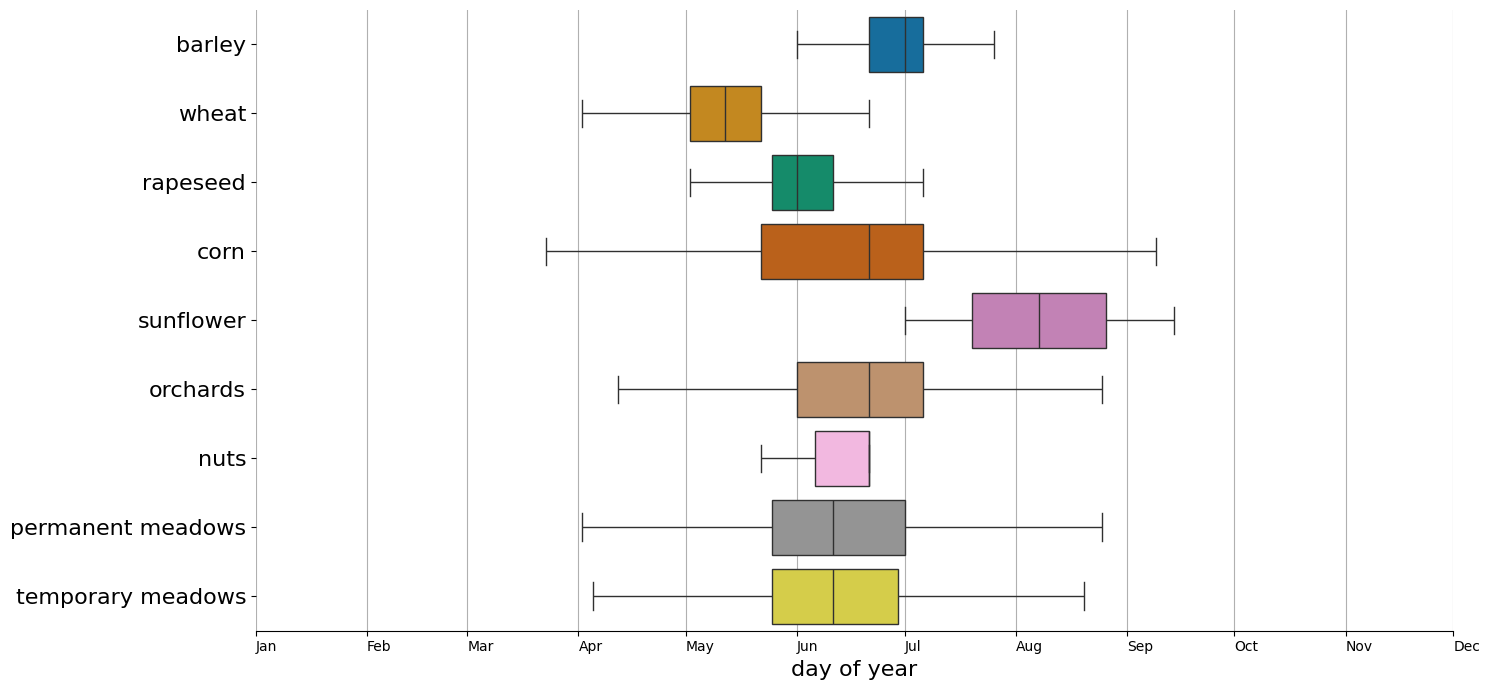

In [133]:
# ----------------------------- VISUALIZATION: stopping times -----------------------------
fig_boxplot, ax_boxplot = plt.subplots(figsize=(15, 7))
doys_stop = get_doy_stop(stats, doys_dict_test, approximated=False)
fig_boxplot, _ = boxplot_stopping_times(doys_stop, stats, fig_boxplot, ax_boxplot, class_names)

for class 0 we have 500 samples
for class 1 we have 500 samples
for class 2 we have 500 samples
for class 3 we have 500 samples
for class 4 we have 2 samples
for class 5 we have 500 samples
for class 6 we have 11 samples
for class 7 we have 500 samples
for class 8 we have 500 samples


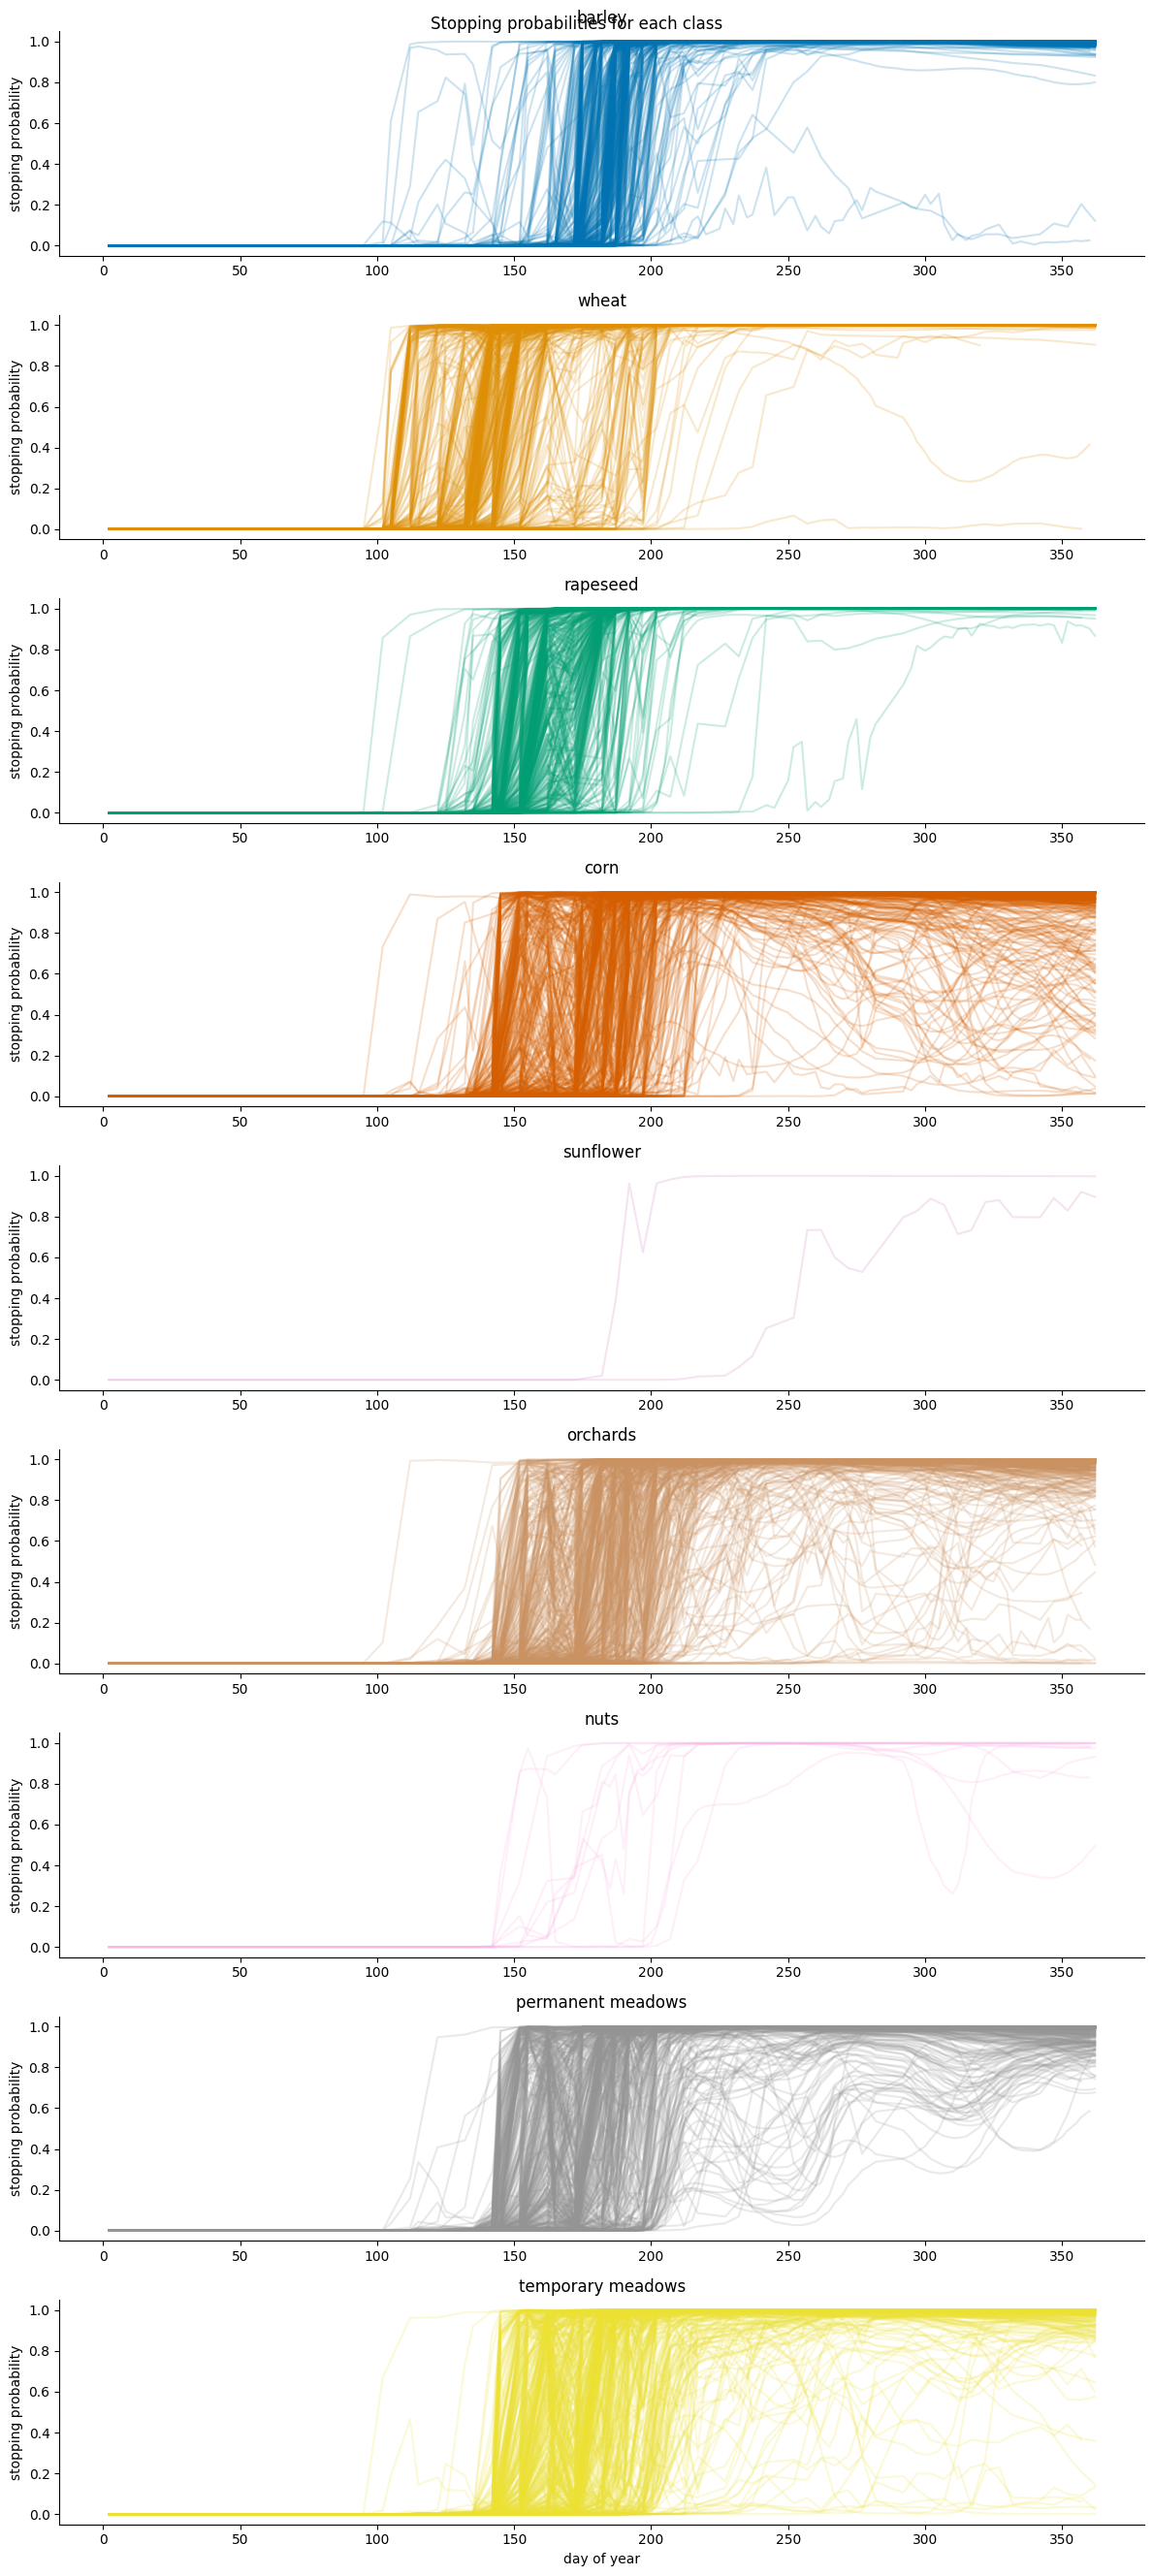

In [134]:
fig, axes = plot_all_doy_probs(stats, doys_dict_test, nclasses=nclasses, class_names=class_names, alpha=0.2, nsamples=500)